In [ ]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

from typing import Any, Optional, List

import qubx
%qubxd #dev 

%load_ext autoreload
%autoreload 2

from qubx import logger
from qubx.core.lookups import lookup
from qubx.core.interfaces import IStrategy, IStrategyContext, TriggerEvent
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.backtester.ome import OrdersManagementEngine
from qubx.trackers import PortfolioRebalancerTracker
from qubx.core.series import Quote
from qubx.data.readers import CsvStorageDataReader, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.core.utils import recognize_time

from qubx.data import loader

def Q(time: str, bid: float, ask: float) -> Quote:
    return Quote(recognize_time(time), bid, ask, 0, 0)


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.1
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# OME simple tests

In [4]:
r = CsvStorageDataReader('../../tests/data/csv')

In [6]:
instr = lookup.find_symbol("BINANCE.UM", "BTCUSDT")
stream = r.read('BTCUSDT_ohlcv_M1', transform=RestoreTicksFromOHLC(trades=False, spread=instr.tick_size))

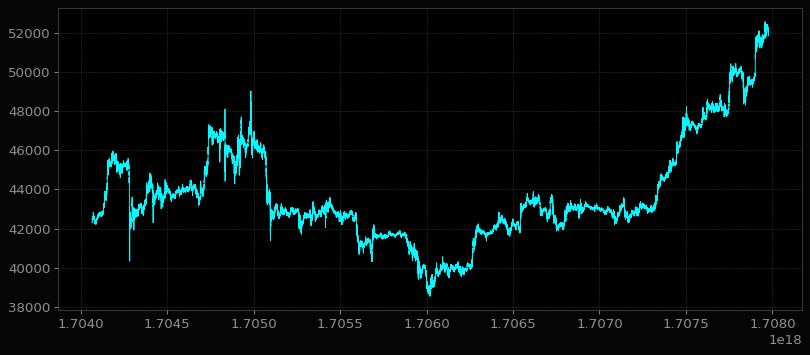

In [7]:
plt.plot(pd.Series({s.time:s.ask for s in stream}))

In [10]:
from qubx.core.basics import ZERO_COSTS, ITimeProvider


class Time(ITimeProvider):
    def g(self, quote: Quote) -> Quote:
        self._time = quote.time
        return quote

    def time(self) -> np.datetime64:
        return self._time

ome = OrdersManagementEngine(instr, t:=Time(), ZERO_COSTS)
ome.update_bbo(t.g(stream[0]))

q0 = stream[0]
ome.place_order("BUY", "MARKET", 0.04, 0, "Test1")
ome.place_order("BUY", "LIMIT", 0.04, q0.bid - 100, "Test2")
ome.place_order("BUY", "LIMIT", 0.1, q0.bid - 100, "Test21")
ome.place_order("SELL", "LIMIT", 0.04, q0.ask + 100, "Test3")
ome.place_order("SELL", "LIMIT", 0.14, q0.ask + 50, "Test31")
ome.place_order("SELL", "LIMIT", 0.3, q0.ask, "Test32")
ome.place_order("BUY", "LIMIT", 0.12, q0.bid, "Test4")

OmeReport(timestamp=1704067201000000000, order=Order(id='SIM-ORDER-BTCUSDT-100007', type='LIMIT', instrument=BINANCE.UM:FUTURE:BTCUSDT, time=1704067201000000000, quantity=0.12, price=42313.95, side='BUY', status='OPEN', time_in_force='gtc', client_id='Test4', cost=0.0, options={}), exec=None)

In [11]:
ome.get_open_orders()

[Order(id='SIM-ORDER-BTCUSDT-100002', type='LIMIT', instrument=BINANCE.UM:FUTURE:BTCUSDT, time=1704067201000000000, quantity=0.04, price=42213.95, side='BUY', status='OPEN', time_in_force='gtc', client_id='Test2', cost=0.0, options={}),
 Order(id='SIM-ORDER-BTCUSDT-100003', type='LIMIT', instrument=BINANCE.UM:FUTURE:BTCUSDT, time=1704067201000000000, quantity=0.1, price=42213.95, side='BUY', status='OPEN', time_in_force='gtc', client_id='Test21', cost=0.0, options={}),
 Order(id='SIM-ORDER-BTCUSDT-100004', type='LIMIT', instrument=BINANCE.UM:FUTURE:BTCUSDT, time=1704067201000000000, quantity=0.04, price=42414.05, side='SELL', status='OPEN', time_in_force='gtc', client_id='Test3', cost=0.0, options={}),
 Order(id='SIM-ORDER-BTCUSDT-100005', type='LIMIT', instrument=BINANCE.UM:FUTURE:BTCUSDT, time=1704067201000000000, quantity=0.14, price=42364.05, side='SELL', status='OPEN', time_in_force='gtc', client_id='Test31', cost=0.0, options={}),
 Order(id='SIM-ORDER-BTCUSDT-100006', type='LIMIT

In [12]:
ome.cancel_order("SIM-ORDER-BTCUSDT-100007")

OmeReport(timestamp=1704067201000000000, order=Order(id='SIM-ORDER-BTCUSDT-100007', type='LIMIT', instrument=BINANCE.UM:FUTURE:BTCUSDT, time=1704067201000000000, quantity=0.12, price=42313.95, side='BUY', status='CANCELED', time_in_force='gtc', client_id='Test4', cost=0.0, options={}), exec=None)

In [13]:
print(ome)

= = (2024-01-01T00:00:01.000000000) = =
  42414.05 : [0.04]
  42364.05 : [0.14]
  42314.05 : [0.3]
- - - - - - - - - - - - - - - - - - - -
  42313.95 : 
  42213.95 : [0.04,0.1]
= = = = = = = = = = = = = = = = = = = =



In [ ]:
for i in range(len(stream)):
    ome.update_bbo(t.g(stream[i]))
    # print(ome)

In [16]:
print(ome)

= = (2024-02-15T06:17:59.000000000) = =
  51950.450000000004 : 
- - - - - - - - - - - - - - - - - - - -
  51950.35 : 
= = = = = = = = = = = = = = = = = = = =



In [17]:
ome.get_open_orders()

[]

# Check correctness of quotes data updates

In [84]:
from qubx.core.basics import DataType, MarketEvent
from qubx.backtester.simulator import simulate

In [151]:
ld = loader("BINANCE.UM", None, source="csv::../../tests/data/csv_quotes/", n_jobs=1)
d = ld['BTCUSDT', '2017-08-24 13:01:12':'2017-08-24 13:09:31']

In [154]:
# plt.step(d.index, d.ask)
# plt.step(d.index, d.bid)
LookingGlass(['step', d.ask, 'step', d.bid, 'step']).look().hover(h=300)

FigureWidget({
    'data': [{'line': {'shape': 'hv'},
              'mode': 'lines',
              'name': 'ask',
              'type': 'scatter',
              'uid': '28554236-0142-4d69-a90f-cf8c2a42b94e',
              'x': array([datetime.datetime(2017, 8, 24, 13, 1, 12),
                          datetime.datetime(2017, 8, 24, 13, 1, 13),
                          datetime.datetime(2017, 8, 24, 13, 1, 14),
                          datetime.datetime(2017, 8, 24, 13, 1, 15),
                          datetime.datetime(2017, 8, 24, 13, 1, 16),
                          datetime.datetime(2017, 8, 24, 13, 1, 17),
                          datetime.datetime(2017, 8, 24, 13, 1, 18),
                          datetime.datetime(2017, 8, 24, 13, 1, 19),
                          datetime.datetime(2017, 8, 24, 13, 1, 20),
                          datetime.datetime(2017, 8, 24, 13, 1, 21),
                          datetime.datetime(2017, 8, 24, 13, 1, 22),
                          datetim

In [155]:
sum((d.ask - d.bid) > 0.1)


28

In [128]:
class QuotesUpdatesTest(IStrategy):
    _market_quotes_called = 0

    def on_init(self, ctx: IStrategyContext) -> None:
        self._market_quotes_called = 0
        self._market_natural_spread = 0

    def on_market_data(self, ctx: IStrategyContext, event: MarketEvent):
        if event.type == DataType.QUOTE:
            q = event.data
            s = q.ask - q.bid
            # print(q, f"{s:.2f} | {event.instrument.tick_size:.2f}")
            self._market_natural_spread += s > event.instrument.tick_size
            self._market_quotes_called += 1

In [129]:
test0 = simulate(
    {
        "test4": (stg := QuotesUpdatesTest()),
    },
    ld,
    capital=100_000,
    instruments=["BINANCE.UM:BTCUSDT"],
    commissions="vip0_usdt",
    debug="DEBUG",
    n_jobs=1,
    start='2017-08-24 13:01:11',
    stop='2017-08-24 13:09:31',
)

2025-03-04 18:26:29.216 [ 🐞 ] (helpers) (InMemoryCachedReader) Loading all data 2017-08-24 13:01:35 - 2017-08-24 15:01:35 for BTCUSDT 
2017-08-24 13:01:11.000 [🐞] [simulator] :: Preparing simulated trading on BINANCE.UM for 100000 USDT...
2017-08-24 13:01:11.000 [ℹ️] SimulatedDataProvider.binance.um is initialized
2017-08-24 13:01:11.000 [🐞] [simulator] :: Setting up default base subscription: quote
2017-08-24 13:01:11.000 [🐞] [simulator] :: Strategy didn't set warmup period for quote so default 1Min will be used


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2017-08-24 13:01:11.000 [🐞] [simulator] :: Subscribing to: quote
2017-08-24 13:01:11.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2017-08-24 13:01:11 :::
2017-08-24 13:01:11.000 [🐞]   [IteratedDataStreamsSlicer] :: Preloading initial data for quote 2017-08-24 13:01:11 : 2017-08-24 13:09:31 ...
2017-08-24 13:01:11.000 [🐞] (InMemoryCachedReader) Updating 1 symbols pre interval 2017-08-24 13:01:11 : 2017-08-24 13:01:35
[2017-08-24T13:01:13.000000000]	10.01000 (100.0) | 10.10000 (20000.0) 0.09 | 0.10
[2017-08-24T13:01:14.000000000]	10.03000 (100.0) | 10.13000 (200.0) 0.10 | 0.10
[2017-08-24T13:01:15.000000000]	10.01000 (100.0) | 10.12000 (20000.0) 0.11 | 0.10
[2017-08-24T13:01:16.000000000]	10.10000 (100.0) | 10.11000 (200.0) 0.01 | 0.10
[2017-08-24T13:01:17.000000000]	10.16000 (100.0) | 10.19000 (200.0) 0.03 | 0.10
[2017-08-24T13:01:18.000000000]	10.16000 (10000.0) | 10.19000 (200.0) 0.03 | 0.10
[2017-08-24T13:01:19.000000000]	10.17000 (100.0) | 10.19000 (200.0) 0.02 | 0.10
[2

In [130]:
stg._market_quotes_called, stg._market_natural_spread

(47, 28)